In [1]:
import numpy as np
import pandas as pd
import featuretools as ft
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Explorartory analysis 
The data can be downloaded from:  NASA Turbofan Engine Degradation Simulation Dataset. In this dataset we have 249 engines (engine_no) which are monitored over time (time_in_cycles). Each engine had operational_settings and sensor_measurements recorded for each cycle. 

In [2]:
data_path = 'train_FD004.txt'
data = utils.load_data(data_path)
print(data.columns.values)
data.head()

Loaded data with:
61249 Recordings
249 Engines
21 Sensor Measurements
3 Operational Settings
['engine_no' 'time_in_cycles' 'operational_setting_1'
 'operational_setting_2' 'operational_setting_3' 'sensor_measurement_1'
 'sensor_measurement_2' 'sensor_measurement_3' 'sensor_measurement_4'
 'sensor_measurement_5' 'sensor_measurement_6' 'sensor_measurement_7'
 'sensor_measurement_8' 'sensor_measurement_9' 'sensor_measurement_10'
 'sensor_measurement_11' 'sensor_measurement_12' 'sensor_measurement_13'
 'sensor_measurement_14' 'sensor_measurement_15' 'sensor_measurement_16'
 'sensor_measurement_17' 'sensor_measurement_18' 'sensor_measurement_19'
 'sensor_measurement_20' 'sensor_measurement_21' 'index' 'time']


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,index,time
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,0,2000-01-01 00:00:00
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,1,2000-01-01 00:10:00
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,2,2000-01-01 00:20:00
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,3,2000-01-01 00:30:00
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,4,2000-01-01 00:40:00


# Remaining Useful Life (RUL) calculation

is the amount of cycles an engine has left before it needs maintenance. What makes this dataset special is that the engines run all the way until failure, giving us precise RUL information for every engine at every point in time.

To train a model that will predict RUL, we can can simulate real predictions on by choosing a random point in the life of the engine and only using the data from before that point. We can create features with that restriction easily by using cutoff_times in Featuretools.

The function make_cutoff_times in utils does that sampling for both the cutoff_time and the label. You can run the next cell several times and see differing results.

In [3]:
cutoff_times = utils.make_cutoff_times(data)

cutoff_times.head()

,engine_no,cutoff_time,RUL
index,,,
1,1,2000-01-03 01:40:00,22
2,2,2000-01-04 18:10:00,78
3,3,2000-01-05 08:30:00,299
4,4,2000-01-08 00:20:00,190
5,5,2000-01-10 09:10:00,42


# Making entity set
To apply Deep Feature Synthesis we need to establish an EntitySet structure for our data. The key insight in this step is that we're really interested in our data as collected by engine. We can create an engines entity by normalizing by the engine_no column in the raw data. In the next section, we'll create a feature matrix for the engines entity directly rather than the base dataframe of recordings.

In [4]:
def make_entityset(data):
    es = ft.EntitySet('Dataset')
    es.entity_from_dataframe(dataframe=data,
                             entity_id='recordings',
                             index='index',
                             time_index='time')

    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='engines',
                        index='engine_no')

    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='cycles',
                        index='time_in_cycles')
    return es
es = make_entityset(data)
es

Entityset: Dataset
  Entities:
    recordings [Rows: 61249, Columns: 28]
    cycles [Rows: 543, Columns: 2]
    engines [Rows: 249, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.time_in_cycles -> cycles.time_in_cycles

# DFS and creating a ML model

With the work from the last section in hand, we can quickly build features using Deep Feature Synthesis (DFS). The function ft.dfs takes an EntitySet and stacks primitives like Max, Min and Last exhaustively across entities. Feel free to try the next step with a different primitive set to see how the results differ!


In [5]:
fm, features = ft.dfs(entityset=es, 
                      target_entity='engines',
                      agg_primitives=['last', 'max', 'min'],
                      trans_primitives=[],
                      cutoff_time=cutoff_times,
                      max_depth=3,
                      verbose=True)
fm.to_csv('simple_fm.csv')

Built 290 features
Elapsed: 04:03 | Remaining: 00:00 | Progress: 100%|██████████████████████████████████████████| Calculated: 11/11 chunks


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

fm = pd.read_csv('simple_fm.csv', index_col='engine_no')
X = fm.copy().fillna(0)
y = X.pop('RUL')

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(type(X_train))
print(type(y_train))

medianpredict1 = [np.median(y_train) for _ in y_test]
print('Baseline by median label: Mean Abs Error = {:.2f}'.format(
    mean_absolute_error(medianpredict1, y_test)))

c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
Baseline by median label: Mean Abs Error = 69.31


In [7]:
recordings_from_train = es['recordings'].df[es['recordings'].df['engine_no'].isin(y_train.index)]
median_life = np.median(recordings_from_train.groupby(['engine_no']).apply(lambda df: df.shape[0]))

recordings_from_test = es['recordings'].df[es['recordings'].df['engine_no'].isin(y_test.index)]
life_in_test = recordings_from_test.groupby(['engine_no']).apply(lambda df: df.shape[0])-y_test

medianpredict2 = (median_life - life_in_test).apply(lambda row: max(row, 0))
print('Baseline by median life: Mean Abs Error = {:.2f}'.format(
    mean_absolute_error(medianpredict2, y_test)))

Baseline by median life: Mean Abs Error = 88.45


In [8]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
    
preds = reg.predict(X_test)
scores = mean_absolute_error(preds, y_test)
print('Mean Abs Error: {:.2f}'.format(scores))
high_imp_feats = utils.feature_importances(X, reg, feats=10)

Mean Abs Error: 33.71
1: MAX(recordings.cycles.LAST(recordings.sensor_measurement_11)) [0.204]
2: MAX(recordings.cycles.LAST(recordings.sensor_measurement_13)) [0.128]
3: LAST(recordings.time_in_cycles) [0.104]
4: MAX(recordings.sensor_measurement_3) [0.085]
5: MAX(recordings.cycles.LAST(recordings.sensor_measurement_3)) [0.046]
6: MAX(recordings.sensor_measurement_11) [0.043]
7: MIN(recordings.cycles.LAST(recordings.sensor_measurement_20)) [0.022]
8: MAX(recordings.cycles.MAX(recordings.sensor_measurement_7)) [0.018]
9: MAX(recordings.cycles.LAST(recordings.sensor_measurement_15)) [0.016]
10: LAST(recordings.cycles.LAST(recordings.sensor_measurement_13)) [0.016]
-----



In [9]:
data2 = utils.load_data('test_FD004.txt')
es2 = make_entityset(data2)
fm2 = ft.calculate_feature_matrix(entityset=es2, features=features, verbose=True)
fm2.head()

Loaded data with:
41214 Recordings
248 Engines
21 Sensor Measurements
3 Operational Settings
Elapsed: 00:18 | Remaining: 00:00 | Progress: 100%|██████████████████████████████████████████| Calculated: 11/11 chunks


,MAX(recordings.sensor_measurement_12),MAX(recordings.sensor_measurement_19),LAST(recordings.sensor_measurement_7),MAX(recordings.sensor_measurement_4),MIN(recordings.sensor_measurement_15),MAX(recordings.sensor_measurement_6),LAST(recordings.sensor_measurement_6),MIN(recordings.sensor_measurement_19),MIN(recordings.operational_setting_2),LAST(recordings.sensor_measurement_2),...,LAST(recordings.cycles.MIN(recordings.sensor_measurement_2)),LAST(recordings.cycles.MIN(recordings.operational_setting_3)),LAST(recordings.cycles.MAX(recordings.sensor_measurement_18)),MIN(recordings.cycles.LAST(recordings.sensor_measurement_16)),LAST(recordings.cycles.LAST(recordings.sensor_measurement_21)),LAST(recordings.cycles.MIN(recordings.sensor_measurement_20)),LAST(recordings.cycles.MAX(recordings.sensor_measurement_12)),MAX(recordings.cycles.MIN(recordings.sensor_measurement_18)),MAX(recordings.cycles.MAX(recordings.sensor_measurement_13)),MAX(recordings.cycles.LAST(recordings.sensor_measurement_2))
engine_no,,,,,,,,,,,,,,,,,,,,,
1,528.34,100.0,176.56,1407.74,8.2953,21.57,8.99,84.93,0.0,537.66,...,535.84,60.0,2388,0.02,17.1118,10.43,526.38,1915,2389.22,642.83
2,522.53,100.0,139.03,1416.30,8.3622,21.61,5.72,84.93,0.0,549.96,...,535.99,60.0,2388,0.02,14.6896,10.39,526.20,1915,2388.70,642.83
3,523.74,100.0,139.26,1403.87,8.3511,21.59,5.69,84.93,0.0,549.47,...,535.88,60.0,2388,0.02,17.1455,10.29,525.85,1915,2388.64,642.83
4,523.40,100.0,175.63,1409.06,8.3564,21.59,9.00,84.93,0.0,536.06,...,536.06,60.0,2388,0.02,14.7103,10.52,533.86,1915,2388.93,642.83
5,521.85,100.0,175.53,1412.33,8.4331,21.61,9.03,84.93,0.0,537.36,...,535.80,60.0,2388,0.02,6.4400,10.39,524.33,1915,2388.45,642.49


In [10]:
X = fm2.copy().fillna(0)
y = pd.read_csv('RUL_FD004.txt', sep=' ', header=-1, names=['RUL'], index_col=False)
preds2 = reg.predict(X)
print('Mean Abs Error: {:.2f}'.format(mean_absolute_error(preds2, y)))

medianpredict1 = [np.median(y_train) for _ in preds2]
print('Baseline by median label: Mean Abs Error = {:.2f}'.format(
    mean_absolute_error(medianpredict1, y)))

medianpredict2 = (median_life - es2['recordings'].df.groupby(['engine_no']).apply(lambda df: df.shape[0])).apply(lambda row: max(row, 0))
print('Baseline by median life: Mean Abs Error = {:.2f}'.format(
    mean_absolute_error(medianpredict2, y)))

Mean Abs Error: 47.50
Baseline by median label: Mean Abs Error = 47.79
Baseline by median life: Mean Abs Error = 49.55


In [11]:
#Prepare data for Keras based LSTM model

def prepareData(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    print(type(X_train))
    X_train = X_train.as_matrix(columns=None)
    X_test = X_test.as_matrix(columns=None)

    print(y_train.shape)
    y_train = y_train.as_matrix(columns=None)
    y_test = y_test.as_matrix(columns=None)

    print(y_train.shape)

    y_train = y_train.reshape((y_train.shape[0], 1))
    y_test = y_test.reshape((y_test.shape[0], 1))

    X_train = np.reshape(X_train,(X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test,(X_test.shape[0], 1, X_test.shape[1]))
    
    return X_train, X_test, y_train, y_test 

In [13]:
#Create LSTM model

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.layers import GaussianNoise

def createLSTMModel(X_train, hidden_neurons):
    model = Sequential()
    model.add(LSTM(hidden_neurons, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(GaussianNoise(0.2))
    model.add(Dense(hidden_neurons))
    model.add(Dropout(0.7))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    
    return model

Using TensorFlow backend.


In [14]:
X_train, X_test, y_train, y_test = prepareData(X, y)
hidden_neurons = 128

model = createLSTMModel(X_train, hidden_neurons)
history = model.fit(X_train, y_train, batch_size=32, nb_epoch=10, validation_split=0.20)

<class 'pandas.core.frame.DataFrame'>


c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


(186, 1)


c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


(186, 1)


c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 148 samples, validate on 38 samples
Epoch 1/10
148/148 [==============================] - ETA: 2s - loss: 10792.799 - 1s 5ms/step - loss: 10482.6740 - val_loss: 10508.8591
Epoch 2/10
148/148 [==============================] - ETA: 0s - loss: 9522.94 - 0s 224us/step - loss: 9920.1897 - val_loss: 10043.5324
Epoch 3/10
148/148 [==============================] - ETA: 0s - loss: 6540.68 - 0s 197us/step - loss: 9495.4229 - val_loss: 9621.4186
Epoch 4/10
148/148 [==============================] - ETA: 0s - loss: 7942.69 - 0s 237us/step - loss: 9098.3312 - val_loss: 9209.7639
Epoch 5/10
148/148 [==============================] - ETA: 0s - loss: 10433.939 - 0s 210us/step - loss: 8681.4976 - val_loss: 8797.8880
Epoch 6/10
148/148 [==============================] - ETA: 0s - loss: 8918.13 - 0s 197us/step - loss: 8270.0115 - val_loss: 8382.7075
Epoch 7/10
148/148 [==============================] - ETA: 0s - loss: 7482.58 - 0s 196us/step - loss: 7798.4729 - val_loss: 7968.7201
Epoch 8/10
1

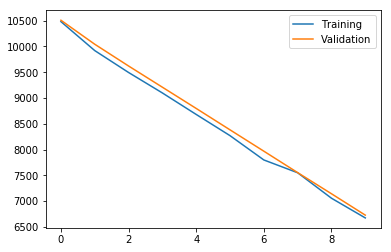

In [15]:
# plot history
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

Interestingly, we can see that test loss drops below training loss. The model may be overfitting the training data. Measuring and plotting RMSE during training may shed more light on this.

In [16]:
#Mean Abs Error by RF: 48.05
#Baseline by median label: Mean Abs Error = 49.35
#Baseline by median life: Mean Abs Error = 49.71
#Mean Abs Error by LSTM: 46.32

predicted = model.predict(X_test)
rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))
print(rmse)

print('Mean Abs Error: {:.2f}'.format(mean_absolute_error(predicted, y_test)))

[74.24878872]
Mean Abs Error: 59.79


# Improvig RUL
We also make cutoff times by selecting a random cutoff time from the life of each engine. We're going to make 5 sets of cutoff times to use for cross validation.

In [17]:
from tqdm import tqdm

splits = 10
cutoff_time_list = []

for i in tqdm(range(splits)):
    cutoff_time_list.append(utils.make_cutoff_times(data))

cutoff_time_list[0].head()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.98it/s]


,engine_no,cutoff_time,RUL
index,,,
1,1,2000-01-03 05:00:00,2
2,2,2000-01-04 05:10:00,156
3,3,2000-01-06 01:30:00,197
4,4,2000-01-08 02:40:00,176
5,5,2000-01-09 16:10:00,144


Here is a collection of mean absolute errors from both notebooks. Though we've used averages where possible (denoted by *), the randomness in the Random Forest Regressor and how we choose labels from the train data changes the score.
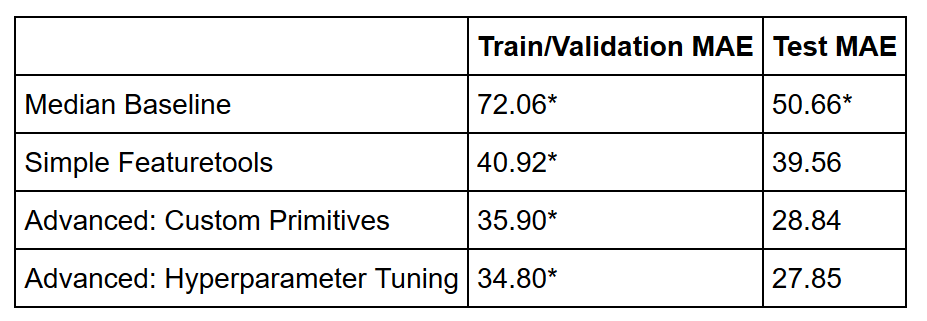	

We're going to do something fancy for our entityset. The values for operational_setting 1-3 are continuous but create an implicit relation between different engines. If two engines have a similar operational_setting, it could indicate that we should expect the sensor measurements to mean similar things. We make clusters of those settings using KMeans from scikit-learn and make a new entity from the clusters.

In [18]:
from sklearn.cluster import KMeans

nclusters = 50

def make_entityset(data, nclusters, kmeans=None):
    X = data[['operational_setting_1', 'operational_setting_2', 'operational_setting_3']]
    if kmeans:
        kmeans=kmeans
    else:
        kmeans = KMeans(n_clusters=nclusters).fit(X)
    data['settings_clusters'] = kmeans.predict(X)
    
    es = ft.EntitySet('Dataset')
    es.entity_from_dataframe(dataframe=data,
                             entity_id='recordings',
                             index='index',
                             time_index='time')

    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='engines',
                        index='engine_no')
    
    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='settings_clusters',
                        index='settings_clusters')
    
    return es, kmeans
es, kmeans = make_entityset(data, nclusters)
es

Entityset: Dataset
  Entities:
    recordings [Rows: 61249, Columns: 29]
    settings_clusters [Rows: 50, Columns: 2]
    engines [Rows: 249, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.settings_clusters -> settings_clusters.settings_clusters

# Step 2: DFS and Creating a Model

In addition to changing our EntitySet structure, we're also going to use the Complexity time series primitive from the package tsfresh. Any function that takes in a pandas Series and outputs a float can be converted into an aggregation primitive using the make_agg_primitive function as shown below.


In [19]:
from featuretools.primitives import make_agg_primitive
import featuretools.variable_types as vtypes

from tsfresh.feature_extraction.feature_calculators import (number_peaks, mean_abs_change, 
                                                            cid_ce, last_location_of_maximum, length)


Complexity = make_agg_primitive(lambda x: cid_ce(x, False),
                              input_types=[vtypes.Numeric],
                              return_type=vtypes.Numeric,
                              name="complexity")

fm, features = ft.dfs(entityset=es, 
                      target_entity='engines',
                      agg_primitives=['last', 'max', Complexity],
                      trans_primitives=[],
                      chunk_size=.26,
                      cutoff_time=cutoff_time_list[0],
                      max_depth=3,
                      verbose=True)

fm.to_csv('advanced_fm.csv')
fm.head()

Built 302 features
Elapsed: 03:01 | Remaining: 00:00 | Progress: 100%|████████████████████████████████████████████| Calculated: 4/4 chunks


,MAX(recordings.sensor_measurement_12),LAST(recordings.operational_setting_1),LAST(recordings.sensor_measurement_3),MAX(recordings.sensor_measurement_19),LAST(recordings.sensor_measurement_7),MAX(recordings.sensor_measurement_4),COMPLEXITY(recordings.sensor_measurement_3),MAX(recordings.sensor_measurement_6),COMPLEXITY(recordings.sensor_measurement_8),COMPLEXITY(recordings.sensor_measurement_13),...,COMPLEXITY(recordings.settings_clusters.COMPLEXITY(recordings.sensor_measurement_10)),MAX(recordings.settings_clusters.LAST(recordings.sensor_measurement_13)),COMPLEXITY(recordings.settings_clusters.MAX(recordings.sensor_measurement_2)),MAX(recordings.settings_clusters.LAST(recordings.sensor_measurement_15)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_14)),COMPLEXITY(recordings.settings_clusters.LAST(recordings.sensor_measurement_17)),LAST(recordings.settings_clusters.LAST(recordings.sensor_measurement_10)),LAST(recordings.settings_clusters.MAX(recordings.sensor_measurement_15)),MAX(recordings.settings_clusters.MAX(recordings.sensor_measurement_5)),RUL
engine_no,,,,,,,,,,,,,,,,,,,,,
1,534.25,10.0009,1512.36,100.0,403.70,1422.53,2701.860435,21.59,3785.206157,3374.886210,...,0.180306,2388.81,951.330984,10.8332,8184.95,729.449107,1.27,8.6160,14.62,2
2,522.54,10.0021,1499.27,100.0,393.99,1406.87,1671.790240,21.61,2388.816692,2158.928532,...,0.171288,2388.10,588.549156,10.8897,8184.95,442.883732,1.26,8.6535,14.62,156
3,525.04,25.0023,1256.26,100.0,176.06,1409.55,1667.702347,21.60,2303.217317,2003.294277,...,0.161997,2388.15,581.203345,10.8552,8184.95,434.812603,0.94,10.9884,14.62,197
4,522.30,10.0005,1507.16,100.0,393.60,1411.32,1544.134426,21.61,2222.217185,2035.267304,...,0.197830,2388.18,544.679645,10.9166,8188.39,403.047144,1.26,8.7092,14.62,176
5,521.43,25.0067,1261.56,100.0,175.22,1417.79,1057.068491,21.61,1413.847978,1193.826372,...,0.122137,2388.22,374.254733,10.9334,8210.13,273.515996,0.94,10.9622,14.62,144


We build 4 more feature matrices with the same feature set but different cutoff times. That lets us test the pipeline multiple times before using it on test data.

In [20]:
fm_list = [fm]
for i in tqdm(range(1, splits)):
    fm = ft.calculate_feature_matrix(entityset=make_entityset(data, nclusters, kmeans=kmeans)[0], 
                                     features=features, 
                                     chunk_size=.26, 
                                     cutoff_time=cutoff_time_list[i])
    fm_list.append(fm)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [31:55<00:00, 212.86s/it]


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE

def pipeline_for_test(fm_list, hyperparams={'n_estimators':100, 'max_feats':50, 'nfeats':50}, do_selection=False):
    scores = []
    regs = []
    selectors = []
    for fm in fm_list:
        X = fm.copy().fillna(0)
        y = X.pop('RUL')
        reg = RandomForestRegressor(n_estimators=int(hyperparams['n_estimators']), 
                                    max_features=min(int(hyperparams['max_feats']), 
                                                     int(hyperparams['nfeats'])))
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        if do_selection:
            reg2 = RandomForestRegressor(n_jobs=3)
            selector = RFE(reg2, int(hyperparams['nfeats']), step=25)
            selector.fit(X_train, y_train)
            X_train = selector.transform(X_train)
            X_test = selector.transform(X_test)
            selectors.append(selector)
        reg.fit(X_train, y_train)
        regs.append(reg)
        
        preds = reg.predict(X_test)
        scores.append(mean_absolute_error(preds, y_test))
    return scores, regs, selectors    
scores, regs, selectors = pipeline_for_test(fm_list)
print([float('{:.1f}'.format(score)) for score in scores])
print('Average MAE: {:.1f}, Std: {:.2f}\n'.format(np.mean(scores), np.std(scores)))

most_imp_feats = utils.feature_importances(fm_list[0], regs[0])

[33.5, 33.5, 44.7, 34.1, 33.7, 34.7, 34.1, 38.5, 31.1, 40.3]
Average MAE: 35.8, Std: 3.88

1: MAX(recordings.settings_clusters.LAST(recordings.sensor_measurement_11)) [0.058]
2: MAX(recordings.settings_clusters.LAST(recordings.sensor_measurement_13)) [0.054]
3: MAX(recordings.settings_clusters.LAST(recordings.sensor_measurement_8)) [0.052]
4: MAX(recordings.sensor_measurement_11) [0.047]
5: MAX(recordings.sensor_measurement_13) [0.035]
-----



In [22]:
X = fm.copy().fillna(0)
y = X.pop('RUL')
X_train, X_test, y_train, y_test = prepareData(X, y)

<class 'pandas.core.frame.DataFrame'>


c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


(186,)


c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


(186,)


In [23]:
hidden_neurons = 128

model = createLSTMModel(X_train, hidden_neurons)
history = model.fit(X_train, y_train, batch_size=32, nb_epoch=10, validation_split=0.20)

c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 148 samples, validate on 38 samples
Epoch 1/10
148/148 [==============================] - ETA: 2s - loss: 15382.420 - 1s 4ms/step - loss: 18166.6194 - val_loss: 29658.3479
Epoch 2/10
148/148 [==============================] - ETA: 0s - loss: 18520.054 - 0s 224us/step - loss: 17467.6469 - val_loss: 28931.7319
Epoch 3/10
148/148 [==============================] - ETA: 0s - loss: 19434.951 - 0s 234us/step - loss: 16861.9389 - val_loss: 28240.8134
Epoch 4/10
148/148 [==============================] - ETA: 0s - loss: 20264.468 - 0s 271us/step - loss: 16350.5290 - val_loss: 27564.7133
Epoch 5/10
148/148 [==============================] - ETA: 0s - loss: 13492.925 - 0s 247us/step - loss: 15922.7467 - val_loss: 26889.1942
Epoch 6/10
148/148 [==============================] - ETA: 0s - loss: 18859.384 - 0s 237us/step - loss: 15410.6005 - val_loss: 26173.5042
Epoch 7/10
148/148 [==============================] - ETA: 0s - loss: 21051.638 - 0s 247us/step - loss: 14867.7348 - val_loss: 25

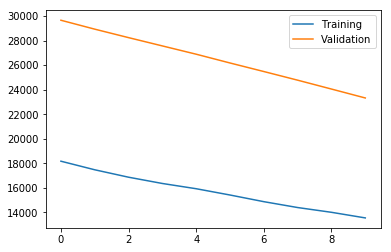

In [24]:
# plot history
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [25]:
#Mean Abs Error by RF: 48.05
#Baseline by median label: Mean Abs Error = 49.35
#Baseline by median life: Mean Abs Error = 49.71
#Mean Abs Error by LSTM: 46.32

predicted = model.predict(X_test)
rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))
print(rmse)

print('Mean Abs Error: {:.2f}'.format(mean_absolute_error(predicted, y_test)))

[112.36771034]
Mean Abs Error: 84.33
